## Importing the necessary libraries

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud,STOPWORDS
from collections import Counter
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import plotly.express as px
from helper import clean_text,trim_sentence
from tqdm.notebook import tqdm
import json
import config
from helper import read_data_file
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ravikumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Import data

In [4]:
dataset = pd.read_csv(config.raw_dataset_file)
pd.set_option('max_colwidth', 400)
print(f"Number of Rows    : {dataset.shape[0]}\nNumber of Columns : {dataset.shape[1]}")
dataset.head()

Number of Rows    : 50000
Number of Columns : 2


review  \
0  One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regard...   
1  A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the ref...   
2  I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof...   
3  Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Paren...   
4  Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action t...   

  sentiment  
0  positive  
1  positive  
2  positive  
3  negative  
4  positive

In [5]:
dataset['review'].iloc[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

## Stastics on dataset

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


There are two columns, review and sentiment, with samples 5000.

In [ ]:
dataset.describe()


By observation, there are 50k counts/samples, have two unique labels/classes (postive/negative).
there are 5 samples frequently occured, which means, repeated reviews. Let's see them.

In [7]:
review_text,num_count = Counter(dataset.review).most_common(3)[0]
print(f"Below text repeated {num_count} times.\n\n {review_text}")

Below text repeated 5 times.

 Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.


In [8]:
for cout in Counter(dataset.review).most_common(3):
    print(f"Below text repeated {cout[1]} times. \n\n {cout[0]}\n")
    print("="*110)

Below text repeated 5 times. 

 Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.

Below text repeated 4 times. 

 Hilarious, clean, light-hearted, and quote-worthy. What else can you ask for in a film? This is my all-time, number one favorite movie. Ever s

In [9]:
max_rep = max(list(Counter(dataset.review).values()))
print(f"Maximum times repeated  {max_rep}")

Maximum times repeated  5


we can see the review are duplicated.


In [10]:
dataset.drop_duplicates(['review','sentiment'],inplace=True)
print(f"Number of Rows    : {dataset.shape[0]}\nNumber of Columns : {dataset.shape[1]}")

Number of Rows    : 49582
Number of Columns : 2


## missing values

In [11]:
dataset.isnull().sum()

review       0
sentiment    0
dtype: int64

## Sentiment class counts

In [12]:
fig = px.histogram(dataset, x="sentiment",
                   color = 'sentiment',
                  title = 'Number of reviews per classes',
                  text_auto=True,
                  )
fig.show()

Above graph shows us distribution is 24.88k and 24.69K, for class postive and negative, respectively.

#### Are there any words follows with # tags?

In [13]:
taged_words_len = len(dataset.review.str.extractall(r'(\#\w+)')[0].value_counts())
print(f"There are {taged_words_len} # taged words")

There are 83 # taged words


In [14]:
tag_data = dataset.review.str.extractall(r'(\#\w+)')[0][:40]
fig = px.histogram(x = tag_data,
            color = tag_data.tolist(),
            labels = {'x' : "tag words"},
            title = 'Words follws with # tags',
            )
fig.show()

## Positive Review Text

### Representing text data in which the size of each word indicates its frequency

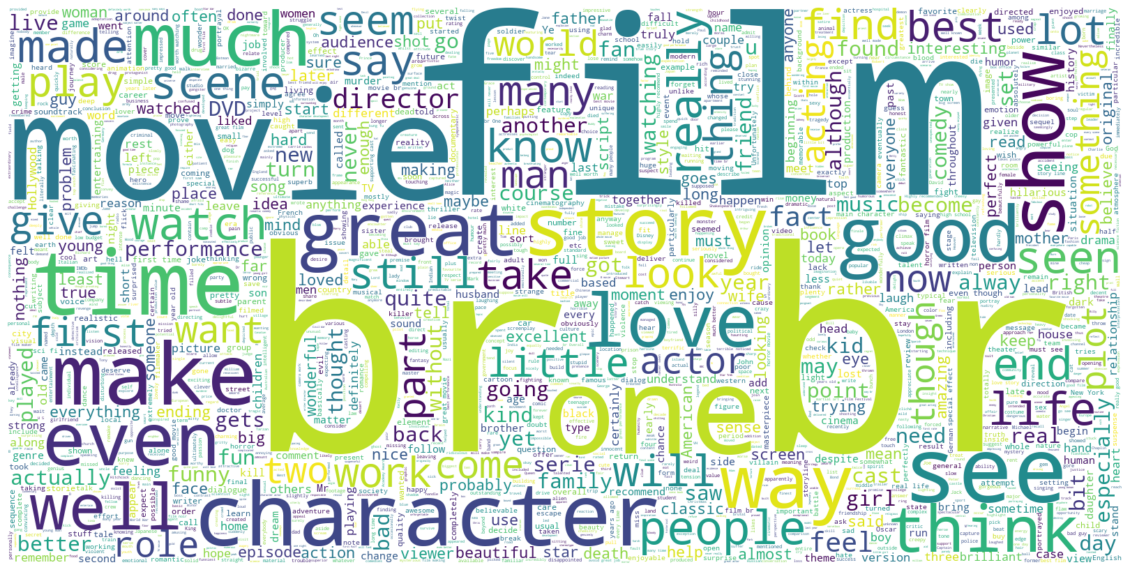

In [15]:
dataset['sentiment'] = dataset['sentiment'].map(config.mapping)
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800, background_color="white").generate(" ".join(dataset[dataset.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Negative Review Text

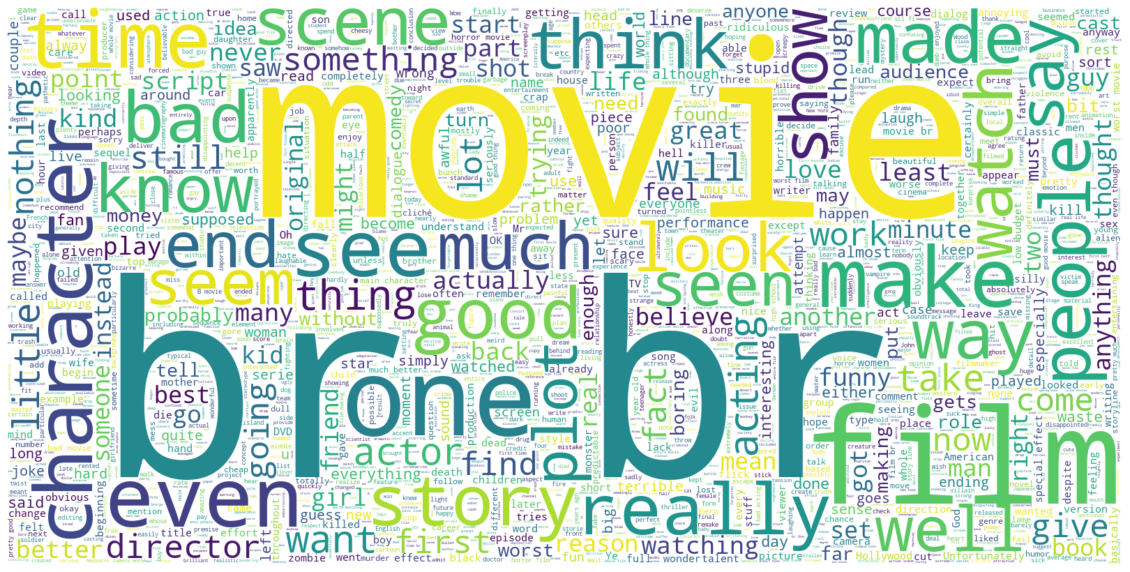

In [16]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800,background_color="white").generate(" ".join(dataset[dataset.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [17]:
review_len = [len(text.split()) for text in dataset.review]
dataset['review_len'] = review_len
fig = px.histogram(dataset,x = 'review_len')
fig.show()

## Preprocessing text

In [18]:
dataset.review = dataset.review.apply(lambda x : clean_text(x))
trimed_sentence = trim_sentence(dataset.review)
dataset['trimmed_review'] = trimed_sentence

### min word len size review

In [19]:
df = dataset[dataset['review_len'] == min(review_len)]
print(f"min word review length is {list(df['review_len'])[0]}")

min word review length is 4


### max word len size review


In [20]:
df = dataset[dataset['review_len'] == max(review_len)]
print(f"Max word review length is {list(df['review_len'])[0]}")
df = dataset[dataset['review_len'] == min(review_len)]

dataset['review_len'].describe()
dataset[dataset['review_len'] < 10]
dataset[dataset['review_len'] < 300].shape
all_words = [word for sentence in dataset['review'] for word in sentence.split()]
counts = Counter(all_words)
most_common_words_dict = dict(counts.most_common(100))
words = most_common_words_dict.keys()
word_counts = most_common_words_dict.values()
fig = px.bar(x =words,y =word_counts,
             color = words,
             title = 'most common 100 words count',
             hover_name=words,
            labels = {'x':"words",'y':"word counts"})
fig.show()


Max word review length is 2470


## Average word length in text (positive and negative review)

In [21]:
word_positive =dataset[dataset['sentiment']==1]['review'].str.split().apply(lambda x : [len(i) for i in x])
word_positive = word_positive.map(lambda x: np.mean(x))
word_negative =dataset[dataset['sentiment']==0]['review'].str.split().apply(lambda x : [len(i) for i in x])
word_negative = word_negative.map(lambda x: np.mean(x))
fig = px.histogram(word_positive,
                  marginal = 'box',
                  labels = {'value' : 'reviews'},
                  title = "Average word length in text (Positive Review)",
                  height=500,width = 1000,
                  )
fig.show()

In [22]:
fig = px.histogram(word_negative,
                  marginal = 'box',
                  labels = {'value' : 'reviews'},
                  title = "Average word length in each text (Negative Review)",
                  height=500,width = 1000,
                  color_discrete_sequence=['indianred'],
                  )
fig.show()

In [23]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=word_positive,
                          name = 'Positive review',
                          marker_color = '#00FF00',
                          opacity=0.75))
fig.add_trace(go.Histogram(x=word_negative,
                          name = 'Negative review',
                          marker_color = '#FF0000',
                          opacity=0.75))

fig.update_layout(title_text = "Average word length in a both classes",
                  xaxis_title_text = 'reviews',
                  yaxis_title_text = 'Count',
                  barmode='stack')
fig.show()

In [ ]:
vocab = set()
for sentence in tqdm(dataset['trimmed_review']):
    for word in sentence.split():
        vocab.add(word)
word2index = {'PAD' : 0,'SOS':1,'EOS':2,'UNK':3}
index2word = {0:'PAD',1:'SOS',2:'EOS',3 : 'UNK'}
        
for idx,word in enumerate(vocab,start = 4):
    word2index[word] = idx
    index2word[idx] = word       
        

json.dump(
    {
      "word2index" : word2index,
      "index2word" : index2word,
      "vocab_len" : len(word2index)
    },
    open(config.vocab_file_name,"w")) 
sentence_len = list()
for sentence in dataset['trimmed_review']:
    sentence_len.append(len(sentence.split()))      
dataset['review_len'] = sentence_len

### Saving the dataframe as csv

In [24]:
df = dataset[['trimmed_review','sentiment','review_len']]
config.base_dir + config.preprocessed_dataset_file
df.to_csv(config.preprocessed_dataset_file,index = False)
pd.read_csv(config.preprocessed_dataset_file).head()

trimmed_review  \
0  one of the other reviewer ha mentioned that after watching just oz episode you ll be hooked they are right a this is exactly what happened with me the first thing that struck me about oz wa it utality and unflinching scene of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pull no punch with regard to drug sex or violence its is...   
1  a wonderful little production the filming technique is very unassuming very old time bbc fashion and give a comforting and sometimes discomforting sense of realism to the entire piece the actor are extremely well chosen michael sheen not only ha got all the polari but he ha all the voice down pat too you can truly see the seamless editing guided by the reference to williams diary entry not onl...   
2  i thought this wa a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a light hearted comedy the plot is simplistic but the dialogue is witty and the character are likable even the well ead suspected serial killer while some may be disappointed when they realize this is not match point risk addiction i thought it wa proof that woody all...   
3  basically there s a family where a little boy jake think there s a zombie in his closet his parent are fighting all the time this movie is slower than a soap opera and suddenly jake decides to become rambo and kill the zombie ok first of all when you re going to make a film you must decide if it a thriller or a drama as a drama the movie is watchable parents are divorcing arguing like in real ...   
4  petter mattei s love in the time of money is a visually stunning film to watch mr mattei offer u a vivid portrait about human relation this is a movie that seems to be telling u what money power and success do to people in the different situation we encounter this being a variation on the arthur schnitzler s play about the same theme the director transfer the action to the present time new yor...   

   sentiment  review_len  
0          1         307  
1          1         162  
2          1         166  
3          0         138  
4          1         230